# Investigating Earthquakes from 1900~ 2016
### Keenan Zucker and James Jang

This notebook aims to explore the iterations we went through when working with Earthquake data and trying to come up with an interesting story

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

import re

%matplotlib inline

In [19]:
quakes = pd.read_csv("./downloaded/data.csv")

### Initial Data Exploration

We explored the data individually and accumulated some of the important information we found with explanation and our thought process

Put the magnitude classification graph
depth classification graph

basemap - keenan marked with magnitude
add both code for the whole thing and just comment one of them out

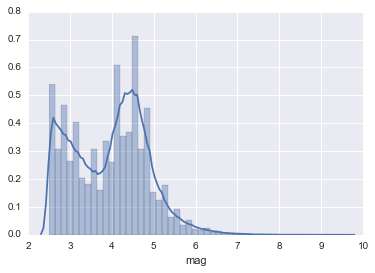

In [42]:
sns.distplot(quakes.mag)

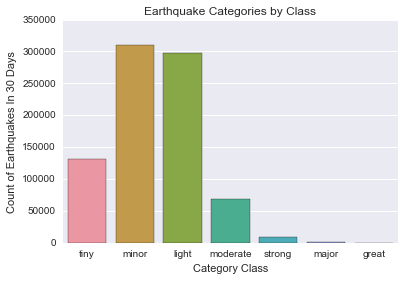

In [45]:
tiny = len(quakes[(quakes.mag < 3)])
minor = len(quakes[(quakes.mag < 4)])
light = len(quakes[(quakes.mag >= 4) & (quakes.mag < 5)])
moderate = len(quakes[(quakes.mag >= 5) & (quakes.mag < 6)])
strong = len(quakes[(quakes.mag >= 6) & (quakes.mag < 7)])
major = len(quakes[(quakes.mag >= 7) & (quakes.mag < 8)])
great = len(quakes[(quakes.mag >= 8)])

names=['tiny', 'minor', 'light', 'moderate', 'strong', 'major', 'great']
counts=[tiny, minor, light, moderate, strong, major, great]

sns.barplot(names, counts)
sns.plt.title("Earthquake Categories by Class")
sns.axlabel("Category Class", "Count of Earthquakes In 30 Days")

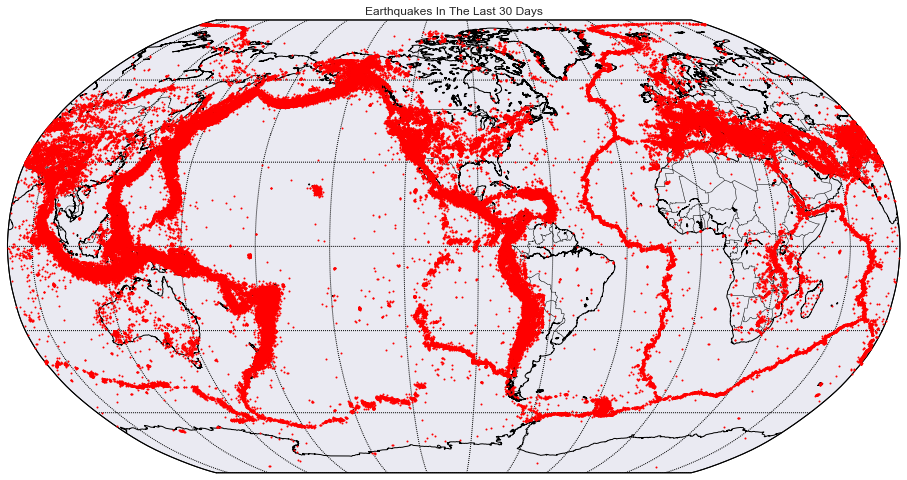

In [47]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(16,12))

my_map = Basemap(projection='robin', lat_0=0, lon_0=-100,
              resolution='l', area_thresh=1000.0)

lats = np.array(quakes.latitude)
longs = np.array(quakes.longitude)
mags = np.array(quakes.mag)
# print lats

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))

x,y = my_map(longs, lats)
my_map.plot(x, y, 'ro', markersize=2.0)
    
plt.title('Earthquakes In The Last 30 Days')
plt.show()

### Models

Only looked at logistic and random forest classifer

add more models?

In [37]:
logistic = LogisticRegression()
random = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

models = {'Logistic': logistic, 'RandomForest': random}

Helper functions to help us iterate

In [38]:
def cross_validate(model, X, y, cv=3):
    return cross_validation.cross_val_score(model, X, y, cv=cv).mean()

def train_test_splitter(model, X, y, train_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, model

# iterates over all different models and print out their results of train_test_splitter
def test_models(models, X, y):
    for modelName, model in models.iteritems():
        print modelName
        X_train, X_test, y_train, y_test, model = train_test_splitter(model, X, y, train_size=0.5)
        print model.score(X_test, y_test)

### Data Cleaning/Feature Engineering

How we created magClassified
depth classified
year

explain how each addition of columns helped the score

trying to map lat long into something

In [33]:
def magclassify(mag):
    if mag < 4:
        return 0
    elif mag < 5:
        return 1
    elif mag < 6:
        return 2
    elif mag < 7:
        return 3
    elif mag < 8:
        return 4
    elif mag >= 8:
        return 5
    
# def magclassify(mag):
#     if mag < 3:
#         return 0
#     elif mag < 4:
#         return 1
#     elif mag < 5:
#         return 2
#     elif mag < 6:
#         return 3
#     elif mag < 7:
#         return 4
#     elif mag < 8:
#         return 5
#     elif mag >= 8:
#         return 6
# "minor" "light" "moderate" "strong" "major" "great"   

def classifyMagType(magType):
    duration = ["Md", "md"]
    local = ["ml"]
    shortPS = ["mb_lg", "lg", "mblg"]
    shortPeriodWave = ["mb"]
    twenty = ["ms", "ms_20"]
    moment = ["mi", "mwp"]
    energy = ["me"]
    
    mw = ["mw", "mwb", "mwc","mwr","mww"]
    magType = str(magType).lower()
    if magType in duration:
        return 0
    elif magType in local:
        return 1
    elif magType in shortPS:
        return 2
    elif magType in shortPeriodWave:
        return 3
    elif magType in twenty:
        return 4
    elif magType in moment:
        return 5
    elif magType in energy:
        return 6
    elif magType in mw:
        return 7
    else:
        return 8    

def depthClassify(depth):
    if depth <20:
        return 0
    elif depth <40:
        return 1
    elif depth <60:
        return 2
    elif depth <80:
        return 3 
    elif depth < 300:
        return 4
    elif depth <700:
        return 5
    else:
        return 6 
    
def parse_date(Dates):
    return int(Dates[0:4]), int(Dates[5:7]), int(Dates[8:10]), int(Dates[11:13])

In [34]:
def add_features():
    quakes["magClassified"] = quakes["mag"].apply(magclassify)
    quakes["depth"] = quakes["depth"].fillna(quakes["depth"].median())
    quakes["magTypeClassified"] =  quakes["magType"].apply(classifyMagType)
    quakes["year"] = quakes.time.apply(lambda x: parse_date(x)[0])
    quakes["month"] = quakes.time.apply(lambda x: parse_date(x)[1])
    quakes["hour"] = quakes.time.apply(lambda x: parse_date(x)[3])
    quakes["depthClassified"] = quakes.depth.apply(depthClassify)
    quakes["country"] = quakes.place.apply(lambda x: str(x).split(", ")[-1])

In [35]:
add_features()

In [48]:
predictors = ["latitude", "longitude", "depth", "year"]
test_models(models, quakes[predictors], quakes.magClassified)

RandomForest
0.807761060195
Logistic
0.695782045161


### Tuning

Logloss 

maybe logistic

### Anaylzing Model's performance

We wanted to see how our model was behaving. We were initially surprised by how well our model performed so we wanted to dissected its performance. 

randomforest does better because it classifies the lat long better

conclusion is that predictions were boring

In [40]:
from sklearn.metrics import classification_report

predictors = ["latitude", "longitude", "depth"]
X_train, X_test, y_train, y_test, model = train_test_splitter(random, quakes[predictors], quakes.magClassified)
y_pred = model.predict(X_test)

target_names = ["minor" "light" "moderate" "strong" "major" "great"]
# print(classification_report(y_test, y_pred, target_names=target_names))
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      0.88      0.88    154846
          1       0.71      0.87      0.79    149276
          2       0.43      0.06      0.11     33953
          3       0.46      0.04      0.07      4722
          4       0.00      0.00      0.00       650
          5       0.00      0.00      0.00        37

avg / total       0.76      0.78      0.75    343484



### Heatmap

basically nothing interesting

### Clustering using DBSCAN

link to DBSCAN

couldnt get what we wanted

### Transition to focusing on California

The predictions that we made with the world's earthquake data weren't all that interesting so we decided to focus on a specific region, California. California is known for many earthquake occurrences because San Andreas fault line goes through California.
Explain more about transitioning and what we wanted to figure out

kernal density and magClassified predictor to get the probability. multiply those values

kernal density plot here and 

when we multiply the kernal density plot value by the probably distribution then we should get the real probability